In [1]:
import copy
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

import numpy as np
import sys, pickle, os, torch, cv2
# replace this path with path to GMIC
#sys.path.append("/path/to/GMIC")

from src.data_loading import loading
from src.modeling import gmic3d as gmic3d
from src.constants import VIEWS, PERCENT_T_DICT, TOP_K_DICT

### You need to obtain the cropped images (bash run.sh) before using this demo.

Step 1: prepare the input data

In [2]:
with open("sample_output/data.pkl", "rb") as f:
    exam_list = pickle.load(f)
datum = exam_list[1]
view = "R-MLO"
short_file_path = datum[view][0]

Step 2: load the image

In [3]:
loaded_image = loading.load_dbt_image(
    image_path=os.path.join("sample_output/cropped_images/", short_file_path + ".nii.gz"),
    view=view,
    horizontal_flip=datum["horizontal_flip"],
)

Step 3: preprocess the image

In [4]:
loaded_image = loading.process_dbt_image(loaded_image, view, datum["best_center"][view][0])

Let's visualize one slice of a sample image

In [5]:
slice_idx = 20

(57, 2116, 1339)


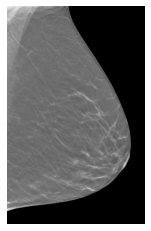

In [6]:
print(loaded_image.shape)
plt.imshow(loaded_image[slice_idx], cmap="Greys_r")
plt.axis("off")
plt.show()

Step 4: load the model

In [7]:
model_index = "1"
device_type = "cpu"

In [8]:
parameters = {
    "device_type": device_type,
    "gpu_number": 0,
    # model related hyper-parameters
    "K": TOP_K_DICT[str(model_index)],
    "percent_t": PERCENT_T_DICT[str(model_index)],
    "crop_shape": (256, 256),
    "post_processing_dim":256,
    "num_classes":2,
    "use_v1_global":False, 
    "half": False,
    "norm_class": 'group', # GroupNorm in GlobalNetwork
    "num_groups": 8, # GroupNorm in GlobalNetwork
    "saliency_nonlinearity": 'tanh_relu',
}

In [9]:
model = gmic3d.GMIC3D(parameters).to(device_type)

In [10]:
model.eval()
model.load_state_dict(torch.load(f"models/sample_model_{model_index}.p", map_location=device_type), strict=True)

<All keys matched successfully>

Step 5: inference

In [11]:
num_slices, image_height, image_width = loaded_image.shape
# convert python 3D array into 5D torch tensor in (N,C,D,H,W) format
loaded_image = loaded_image.reshape(
    1, 1, num_slices, image_height, image_width
)

In [12]:
tensor_batch = torch.Tensor(loaded_image).to(device_type)
output = model(tensor_batch)
pred_numpy = output.data.cpu().numpy()
malignant_pred = pred_numpy[0, 1]

In [13]:
print("malignant prediction = {}".format(malignant_pred))

malignant prediction = 0.43399330973625183


Step 6: visualize the saliency map

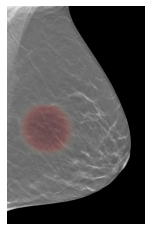

In [14]:
saliency_maps = model.saliency_map.data.cpu().numpy()
malignant_saliency_map = saliency_maps[slice_idx,1,:,:]
alphas = np.abs(np.linspace(0, 0.95, 259))
alpha_red = copy.copy(plt.cm.get_cmap('Reds'))
alpha_red._init()
alpha_red._lut[:, -1] = alphas
plt.figure()
plt.imshow(loaded_image[0,0,slice_idx,:,:], cmap="Greys_r")
plt.imshow(cv2.resize(malignant_saliency_map, (image_width, image_height)), alpha=0.3, cmap=alpha_red, clim=[0.0, 1.0])
plt.axis("off")
plt.show()